# Protein Folding Principles Dataset

In [7]:
import matplotlib.pyplot as plt

In [8]:
#Change root directory to the project root
#This is necessary to import modules from the project
#without having to install them

import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [9]:
## Interactive reloading
#This is useful for Jupyter notebooks to automatically reload modules

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get PDB codes for high quality structures using PISCES

In [18]:
from dataset.pisces import fetch_pisces_table, get_filtered_pdb_codes

# Fetch and filter
pisces_df = fetch_pisces_table()
pdb_ids = get_filtered_pdb_codes(pisces_df)

# Preview results
print(f"Found {len(pdb_ids)} high-quality structures with pdb codes.")
print(pdb_ids[:10])


Detected PISCES columns: ['PDBchain', 'len', 'method', 'resol', 'rfac', 'freerfac']
Found 11116 high-quality structures with pdb codes.
['5D8V', '5NW3', '1UCS', '3X2M', '2VB1', '1US0', '6E6O', '6S2M', '1R6J', '4REK']


## Find beta-beta patterns and their chirality in PDB entries

In [37]:
from dataset.io_utils import fetch_mmcif_file, run_dssp_on_mmcif
from dataset.motif_logic import detect_hairpins_and_chirality, detect_hairpins_and_chirality_backbone
import pandas as pd
import os

#pdb_ids = ["8GBS", "7R1C"]
results_backbone = []
results_exact = []

for pdb_id in pdb_ids[100:500]:
    pdb_path = fetch_mmcif_file(pdb_id)
    try:
        model, dssp_df = run_dssp_on_mmcif(pdb_path, dssp_exe="/opt/anaconda3/envs/folding-dssp/bin/mkdssp")
        if dssp_df is None:
            print(f"DSSP failed for {pdb_id}. Skipping.")
            continue
        hp_df = detect_hairpins_and_chirality_backbone(model, dssp_df)
        results_backbone.append(hp_df)
        hp_df = detect_hairpins_and_chirality(model, dssp_df)
        results_exact.append(hp_df)
    finally:
        # Always remove the file, even if DSSP or parsing fails
        if os.path.exists(pdb_path):
            os.remove(pdb_path)

all_hairpins_backbone = pd.concat(results_backbone, ignore_index=True)
all_hairpins_backbone.head(10)
all_hairpins_exact = pd.concat(results_exact, ignore_index=True)
all_hairpins_exact.head(10)

,PDB,Chain,strand1_start,strand1_end,strand2_start,strand2_end,loop_len,handedness,handedness_magnitude,FullChainSequence,HairpinSequence,LoopSequence
0,3vor,A,69,70,75,76,4,L,-0.555162,GSDSRTVSELVTNTNTIRVAMKDAYQRDGKYPDYQAPLSLTADSIK...,RNGISGDY,GISG
1,3vor,A,75,76,78,83,1,L,-0.622370,GSDSRTVSELVTNTNTIRVAMKDAYQRDGKYPDYQAPLSLTADSIK...,DYIGIGGAI,I
2,3vor,A,78,83,93,101,9,L,-0.681088,GSDSRTVSELVTNTNTIRVAMKDAYQRDGKYPDYQAPLSLTADSIK...,GIGGAITSSGSTINKGFAMELNGL,TSSGSTINK
3,3vor,A,138,139,149,151,9,L,-0.786458,GSDSRTVSELVTNTNTIRVAMKDAYQRDGKYPDYQAPLSLTADSIK...,VNMLAATDNTTILR,MLAATDNTT
4,5gji,A,354,359,368,374,8,L,-0.229098,SNMSLQNAEWYWGDISREEVNEKLRDTADGTFLVRDASTKMHGDYT...,TFLVRDASTKMHGDYTLTLRK,ASTKMHGD
5,5gji,A,368,374,377,386,2,L,-0.244376,SNMSLQNAEWYWGDISREEVNEKLRDTADGTFLVRDASTKMHGDYT...,YTLTLRKGGNNKLIKIFHR,GG
6,5gji,A,377,386,389,391,2,L,-0.420405,SNMSLQNAEWYWGDISREEVNEKLRDTADGTFLVRDASTKMHGDYT...,NNKLIKIFHRDGKYG,DG
7,5gji,A,389,391,398,399,6,L,-0.275373,SNMSLQNAEWYWGDISREEVNEKLRDTADGTFLVRDASTKMHGDYT...,KYGFSDPLTFS,FSDPLT
8,4nsv,A,8,9,25,30,15,R,0.415427,GVSGSCNIDVVCPEGNGHRDVIRSVAAYSRQGTMWCTGSLVNNSAN...,IDVVCPEGNGHRDVIRSVAAYSR,VVCPEGNGHRDVIRS
9,4nsv,A,25,30,33,41,2,R,0.956206,GVSGSCNIDVVCPEGNGHRDVIRSVAAYSRQGTMWCTGSLVNNSAN...,VAAYSRQGTMWCTGSLV,QG


<Axes: xlabel='Loop length', ylabel='Frequency'>

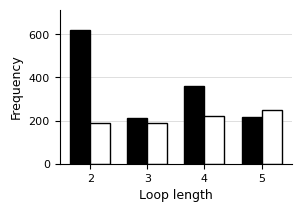

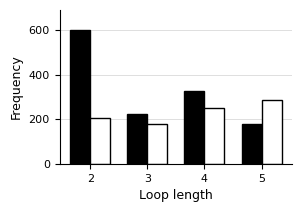

In [43]:
from dataset.plots import plot_loop_length_chirality

plot_loop_length_chirality(all_hairpins_backbone)   
plot_loop_length_chirality(all_hairpins_exact) 

### What are those R hairpins with length 2?

None of these were observed in the paper. Maybe many of those are quite weak magnitude?

In [44]:
all_hairpins_exact[(all_hairpins_exact["loop_len"] == 2) & (all_hairpins_exact["handedness"] == "R")].head(10)


,PDB,Chain,strand1_start,strand1_end,strand2_start,strand2_end,loop_len,handedness,handedness_magnitude,FullChainSequence,HairpinSequence,LoopSequence
9,4nsv,A,25,30,33,41,2,R,0.956206,GVSGSCNIDVVCPEGNGHRDVIRSVAAYSRQGTMWCTGSLVNNSAN...,VAAYSRQGTMWCTGSLV,QG
24,4nsv,B,25,30,33,41,2,R,0.945541,GVSGSCNIDVVCPEGNGHRDVIRSVAAYSRQGTMWCTGSLVNNSAN...,VAAYSRQGTMWCTGSLV,QG
94,2xu3,A,181,186,189,190,2,R,0.116254,APRSVDWREKGYVTPVKNQGQCGSCWAFSATGALEGQMFRKTGRLI...,KYWLVKNSWG,NS
187,5mk9,A,119,120,123,129,2,R,0.416220,GSHMKNVSGSVKLWVDTTQVPYYKKIVANFNKKYPDVKVKVTQSPN...,KMFAYPFAEQA,FA
210,3ea6,A,88,94,97,101,2,R,0.029681,DIGIDNLRNFYTKKDFVDLKDVKDNDTPIANQLQFSNESYDLISES...,YLDKSRNIPINIWI,IP
217,2fvy,A,232,233,236,237,2,R,0.087734,DTRIGVTIYKYDDNFMSVVRKAIEQDAKAAPDVQLLMNDSQNDQSK...,VFGVDA,GV
247,1ok0,A,42,43,46,48,2,R,0.308522,DTTVSEPAPSCVTLYQSWRYSQADNGCAETVTVKVVYEDDTEGLCY...,EGLCYAV,LC
257,6ri6,A,81,82,85,86,2,R,0.755275,AQIGPVTDLHITNANISPDGFSRPAVLAGGTFPGPTIAGNTGDNFQ...,AFVTQC,VT
295,3ql9,A,182,183,186,188,2,R,0.150856,SMGIVSCTACGQQVNHFQKDSIYRHPSLQVLICKNCFKYYMSDDIS...,QKDSIYR,DS
377,2uu8,A,140,144,147,150,2,R,0.626214,ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGK...,LILQGDATTGT,DA


### Plot only strng magnitude ones

<Axes: xlabel='Loop length', ylabel='Frequency'>

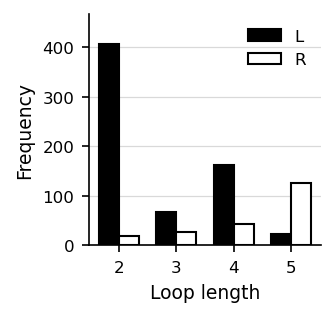

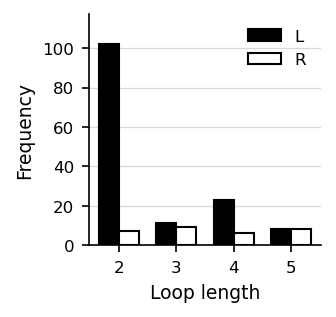

In [51]:
plot_loop_length_chirality(all_hairpins_backbone[all_hairpins_backbone["handedness_magnitude"].abs() > 0.85])
plot_loop_length_chirality(all_hairpins_exact[all_hairpins_exact["handedness_magnitude"].abs() > 0.85])